Game Setup:
Total water available: 65
Minimum bid: 10
Maximum allocation per round: 29

Users:
Farmer: Water need = 37, Budget = 1477
Factory: Water need = 59, Budget = 1440
Homes: Water need = 34, Budget = 955

Round 1
Farmer received 29 units of water, bid: (29, 32)
Factory received 29 units of water, bid: (29, 44)
Homes received 7 units of water, bid: (29, 10)

Round 2
Farmer received 8 units of water, bid: (8, 28.8)
Factory received 16 units of water, bid: (16, 39.6)
Homes received 27 units of water, bid: (27, 12.0)

Round 3
Farmer received 0 units of water, bid: (0, 0)
Factory received 0 units of water, bid: (0, 0)
Homes received 0 units of water, bid: (0, 0)

Game Results:
Farmer: Water Received: 37, Money Spent: 1158.4, Satisfied
Efficiency: 100.00%
Factory: Water Received: 45, Money Spent: 1909.6, Not Satisfied
Efficiency: 76.27%
Homes: Water Received: 34, Money Spent: 394.0, Satisfied
Efficiency: 100.00%
Water Manager earned: 3462.0


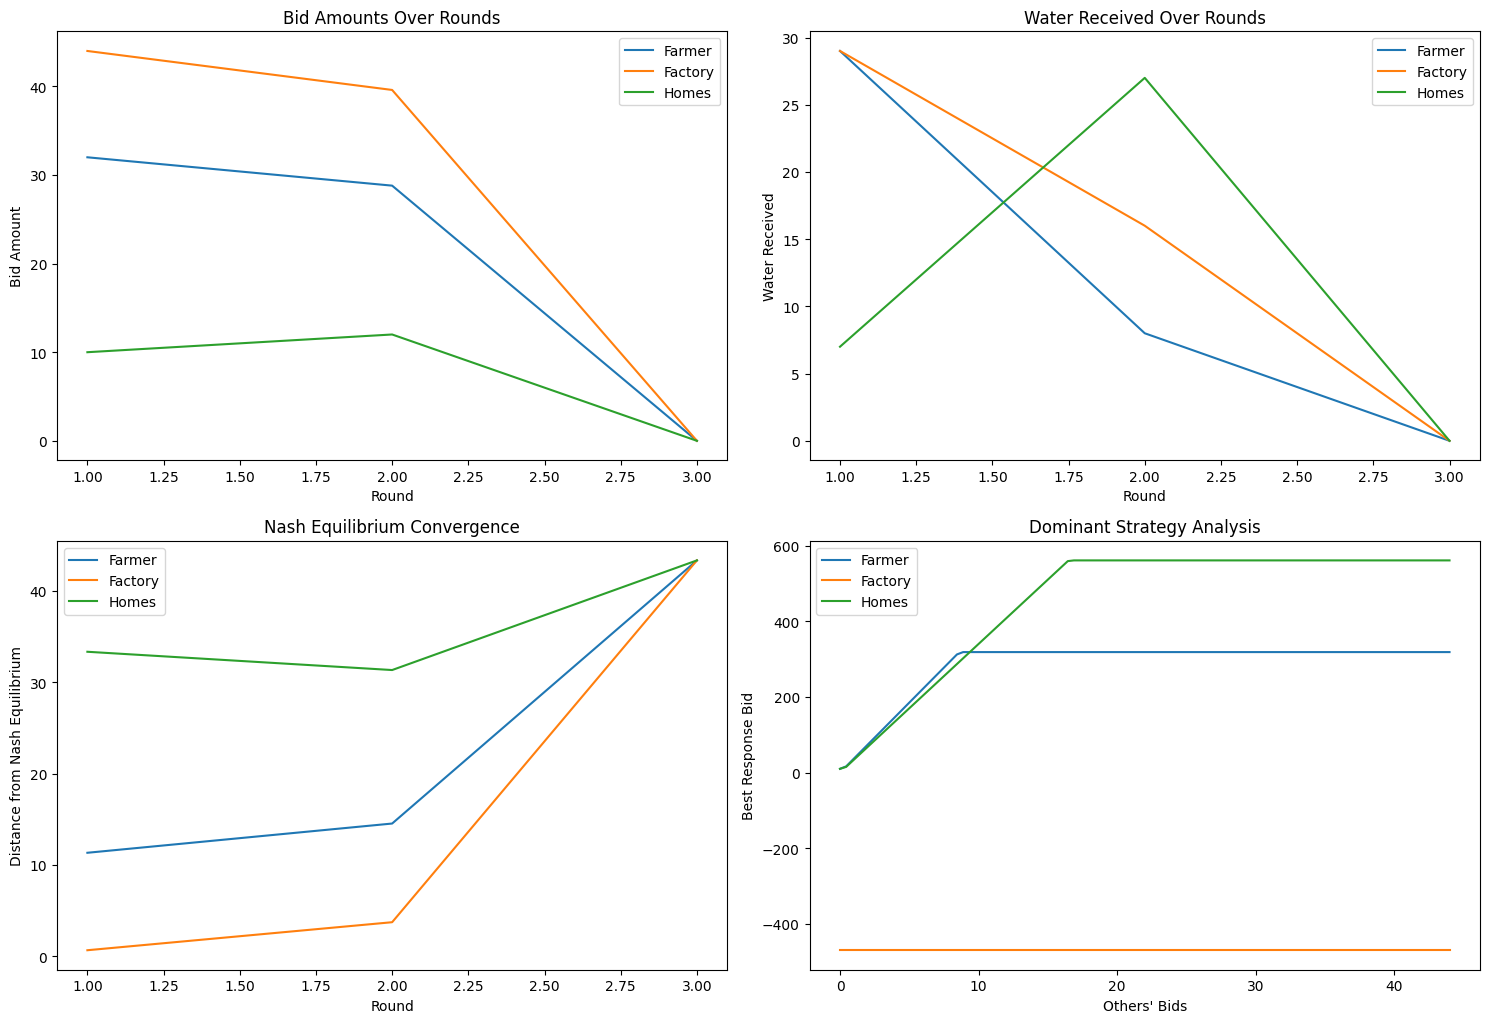

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

class WaterManager:
    def __init__(self, total_water, min_bid, max_allocation):
        self.total_water = total_water
        self.min_bid = min_bid
        self.max_allocation = max_allocation
        self.money_earned = 0

    def allocate_water(self, bids):
        sorted_bids = sorted(bids, key=lambda x: x[1], reverse=True)
        allocations = {user: 0 for user, _ in bids}
        remaining_water = self.total_water

        for user, bid in sorted_bids:
            if remaining_water > 0:
                allocated = min(bid[0], remaining_water, self.max_allocation)
                allocations[user] = allocated
                remaining_water -= allocated
                self.money_earned += bid[1] * allocated

        return allocations

class WaterUser:
    def __init__(self, name, water_need, budget):
        self.name = name
        self.water_need = water_need
        self.budget = budget
        self.total_water_received = 0
        self.money_spent = 0
        self.bids_history = []
        self.water_received_history = []

    def make_bid(self, min_bid, max_allocation, round_num):
        water_still_needed = max(0, self.water_need - self.total_water_received)
        max_affordable_water = min(self.budget // min_bid, max_allocation) if min_bid > 0 else water_still_needed
        water_to_bid = min(water_still_needed, max_affordable_water)

        if water_to_bid > 0:
            max_bid_amount = min(self.budget // water_to_bid, self.budget)
            # Adjust strategy based on previous rounds
            if round_num == 1:
                bid_amount = random.randint(min_bid, max(min_bid, max_bid_amount))
            else:
                prev_bid = self.bids_history[-1]
                if self.water_received_history[-1] < water_to_bid:
                    bid_amount = min(prev_bid * 1.2, max_bid_amount)  # Increase bid if didn't get enough water
                else:
                    bid_amount = max(prev_bid * 0.9, min_bid)  # Decrease bid if got enough water
        else:
            water_to_bid = 0
            bid_amount = 0

        self.bids_history.append(bid_amount)
        return (water_to_bid, bid_amount)

    def receive_water(self, water, price):
        self.total_water_received += water
        self.water_received_history.append(water)
        cost = water * price
        self.money_spent += cost
        self.budget -= cost

def play_round(water_manager, users, round_num):
    print(f"\nRound {round_num}")
    bids = [(user, user.make_bid(water_manager.min_bid, water_manager.max_allocation, round_num)) for user in users]
    allocations = water_manager.allocate_water(bids)

    for user, bid in bids:
        water_received = allocations[user]
        user.receive_water(water_received, bid[1])
        print(f"{user.name} received {water_received} units of water, bid: {bid}")

def plot_graphs(users, water_manager):
    plt.figure(figsize=(15, 15))

    # Existing graphs
    plt.subplot(3, 2, 1)
    for user in users:
        plt.plot(range(1, len(user.bids_history) + 1), user.bids_history, label=user.name)
    plt.title('Bid Amounts Over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Bid Amount')
    plt.legend()

    plt.subplot(3, 2, 2)
    for user in users:
        plt.plot(range(1, len(user.water_received_history) + 1), user.water_received_history, label=user.name)
    plt.title('Water Received Over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Water Received')
    plt.legend()

    # Nash Equilibrium Convergence
    plt.subplot(3, 2, 3)
    nash_equilibrium = sum(user.water_need for user in users) / len(users)
    for user in users:
        plt.plot(range(1, len(user.bids_history) + 1),
                 [abs(bid - nash_equilibrium) for bid in user.bids_history],
                 label=user.name)
    plt.title('Nash Equilibrium Convergence')
    plt.xlabel('Round')
    plt.ylabel('Distance from Nash Equilibrium')
    plt.legend()

    # Dominant Strategy Analysis
    plt.subplot(3, 2, 4)
    max_bid = max(max(user.bids_history) for user in users)
    bid_range = np.linspace(0, max_bid, 100)
    for user in users:
        best_response = [min(user.budget, max(water_manager.min_bid, user.water_need * bid)) for bid in bid_range]
        plt.plot(bid_range, best_response, label=user.name)
    plt.title('Dominant Strategy Analysis')
    plt.xlabel('Others\' Bids')
    plt.ylabel('Best Response Bid')
    plt.legend()

    plt.tight_layout()
    plt.show()

def play_game(total_water, min_bid, max_allocation, users):
    water_manager = WaterManager(total_water, min_bid, max_allocation)

    for round_num in range(1, 4):
        play_round(water_manager, users, round_num)

    print("\nGame Results:")
    for user in users:
        satisfaction = "Satisfied" if user.total_water_received >= user.water_need else "Not Satisfied"
        efficiency = (user.water_need - abs(user.total_water_received - user.water_need)) / user.water_need * 100
        print(f"{user.name}: Water Received: {user.total_water_received}, Money Spent: {user.money_spent}, {satisfaction}")
        print(f"Efficiency: {efficiency:.2f}%")
    print(f"Water Manager earned: {water_manager.money_earned}")

    plot_graphs(users, water_manager)

def generate_users():
    return [
        WaterUser("Farmer", random.randint(30, 50), random.randint(1000, 1500)),
        WaterUser("Factory", random.randint(40, 60), random.randint(1200, 1800)),
        WaterUser("Homes", random.randint(20, 40), random.randint(800, 1200))
    ]

# Game setup
users = generate_users()
total_water = sum(user.water_need for user in users) // 2  # Set total water to half of total demand
min_bid = 10
max_allocation = max(user.water_need for user in users) // 2  # Set max allocation to half of max user need

print(f"Game Setup:")
print(f"Total water available: {total_water}")
print(f"Minimum bid: {min_bid}")
print(f"Maximum allocation per round: {max_allocation}")
print("\nUsers:")
for user in users:
    print(f"{user.name}: Water need = {user.water_need}, Budget = {user.budget}")

play_game(total_water, min_bid, max_allocation, users)